<a href="https://colab.research.google.com/github/Konerusudhir/machine_learning_exercises/blob/master/SemanticSearchV0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Semantic Search on MakersPlace Images**

We fetch MakersPlace images and Index them using Faiss. Search is performed using Query embedding on the index. Below are the individual steps.

1.   Fetch Makers Place Contract NFT Token ids(n ...m) meta data using Alchemy 
     API. Extract previwe image URLs from the response
2.   Fetch images from URLs (IPFS Gateway). Parallell execution is used.
3.   Download Clip Model(openai/clip-vit-large-patch14) from HuggingFace and instantiate TextModel and VIsion Model.
4.   Create Index using Faiss
5.   Generate embeddings for images using Clip Model and them to index
6.   Query the index using Query Image Model Embeddings.
7.   Display search results.

## Acknowledgements
1. Search results in unintended images like NSFW images
2. This is setup is not evaluated using curated/benchmark dataset to verify
   accuracy
3. Index generation and Index search is not on GPU. Only Image embedding generation is in GPU
4. GPU Memory clean up is done manually. Need fine tuning to avoid OOM errors



In [1]:
%%capture
!pip install transformers
!pip install faiss-gpu
!pip install torch
!pip install Pillow
!pip install matplotlib
!pip install python-libmagic

In [2]:
import os
import shutil
import math 
import glob
import json
import pickle
import requests
import time

import numpy as np
from numpy import random
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt

import faiss
import torch

GATEWAY_URL = "https://eth-mainnet.g.alchemy.com/nft/v2/rBshNbJGutTbf2ACdQ9XyGhhc1uSolds/getNFTMetadataBatch"
IPFS_GATEWAY = 'https://ipfsgateway.makersplace.com/ipfs/'
MP_CONTRACT_ADDRESS = "0x2963ba471e265e5f51cafafca78310fe87f8e6d1"
SUPPORTED_CONTENT_TYPES = ['image/jpeg','image/png','image/gif']
IPFS_IMAGE_IDS_FILE_NAME = "ipfs_image_ids.pickle"
INDEX_FOLDER = "./indexes"
IMAGES_FOLDER = "./images"
IPFS_IMAGE_IDS_PATH = os.path.join(INDEX_FOLDER, IPFS_IMAGE_IDS_FILE_NAME)
MIN_TOKEN_ID = 1
MAX_TOKEN_ID = 500
GATEWAY_QUERY_BATCH_SIZE = 100
VISION_MODEL_INPUT_BATCH_SIZE = 8

RANDOM_SEED = 7

np.random.seed(RANDOM_SEED)

In [3]:
def clean_directories():
  shutil.rmtree(IMAGES_FOLDER, ignore_errors=True)
  shutil.rmtree(INDEX_FOLDER, ignore_errors=True)

def create_directories():
  if not os.path.exists(IMAGES_FOLDER):
    os.mkdir(IMAGES_FOLDER) 
  if not os.path.exists(INDEX_FOLDER):
    os.mkdir(INDEX_FOLDER)

# clean_directories()
create_directories()

# 1 - Transactions Fetch

In [4]:
%%time
def read_ipfs_image_ids(image_ids_path):
    if os.path.exists(image_ids_path):
        with open(image_ids_path, 'rb') as f:
            return pickle.load(f)
    else:
        return set()
class FetchClass:
    def __init__(self):
        self.image_duplicates_count = 0

    def fetch_image_urls(self, min_token_id, max_toke_id):  
        token_id_requests = [] 
        for i in range(min_token_id, max_toke_id):
            token_id_requests.append(
                {
                    "contractAddress": MP_CONTRACT_ADDRESS,
                    "tokenId": f"{i}",
                    "tokenType": "ERC721"
                }
            )

        payload = {
            "tokens": token_id_requests,
            "refreshCache": False
        }
        headers = {
            "accept": "application/json",
            "content-type": "application/json"
        }

        responses = requests.post(GATEWAY_URL, json=payload, headers=headers)
        nfts_metadata = json.loads(responses.text)

        for nft_metadata in nfts_metadata:
            imageUrl = nft_metadata['metadata'].get('imageUrl', None)
            if imageUrl:
                ipfs_id = imageUrl.split('/')[-1]
                if ipfs_id not in ipfs_image_ids:
                    ipfs_image_ids.add(ipfs_id)                    
                else:
                    self.image_duplicates_count += 1
                    if self.image_duplicates_count%1000 == 0:
                        print(f"Found {self.image_duplicates_count} duplicates")



ipfs_image_ids = read_ipfs_image_ids(IPFS_IMAGE_IDS_PATH)
fetch_class = FetchClass()
for batch_start_index in range(
    MIN_TOKEN_ID, MAX_TOKEN_ID, GATEWAY_QUERY_BATCH_SIZE):
    fetch_class.fetch_image_urls(
        batch_start_index, 
        batch_start_index+GATEWAY_QUERY_BATCH_SIZE)
    if batch_start_index%1001 == 0:
        print(f"Fetched batch from {batch_start_index}")
    time.sleep(0.3)    

with open(IPFS_IMAGE_IDS_PATH, 'wb') as f:
    pickle.dump(ipfs_image_ids, f)

CPU times: user 11.1 s, sys: 120 ms, total: 11.2 s
Wall time: 28.7 s


# 2 - Fetch Images

In [5]:
%%time
ipfs_image_ids = read_ipfs_image_ids(IPFS_IMAGE_IDS_PATH)
img_local_paths = []
from concurrent.futures import ThreadPoolExecutor
def fetch_image(ipfs_image_id):

  image_url = os.path.join(IPFS_GATEWAY,ipfs_image_id) 
  image_local_path = os.path.join(IMAGES_FOLDER,ipfs_image_id)

  # print(f"{image_url} -- {file_name} -- {image_local_path}")
  
  if not os.path.exists(image_local_path):    
    response = requests.get(image_url)
    content_type = response.headers.get('content-type')
    if response.status_code and content_type in SUPPORTED_CONTENT_TYPES:
        fp = open(image_local_path, 'wb')
        fp.write(response.content)
        fp.close()
        img_local_paths.append(image_local_path)
    else:
        print(f"HTTP Code:{response.status_code} - {content_type} - IPFS ID:{ipfs_image_id}")

with ThreadPoolExecutor(max_workers=32) as executor:
    executor.map(fetch_image, ipfs_image_ids)

downloaded_images_count = len(img_local_paths)
print(f"Downloaded {downloaded_images_count} Images")
image_names = [name for name in os.listdir(IMAGES_FOLDER) if os.path.isfile(os.path.join(IMAGES_FOLDER, name))]
total_images_count = len(image_names)
print(f"Total Images: {total_images_count}")

Downloaded 0 Images
Total Images: 10961
CPU times: user 531 ms, sys: 101 ms, total: 632 ms
Wall time: 638 ms


CPU times: user 1.49 s, sys: 130 ms, total: 1.62 s
Wall time: 1.76 s


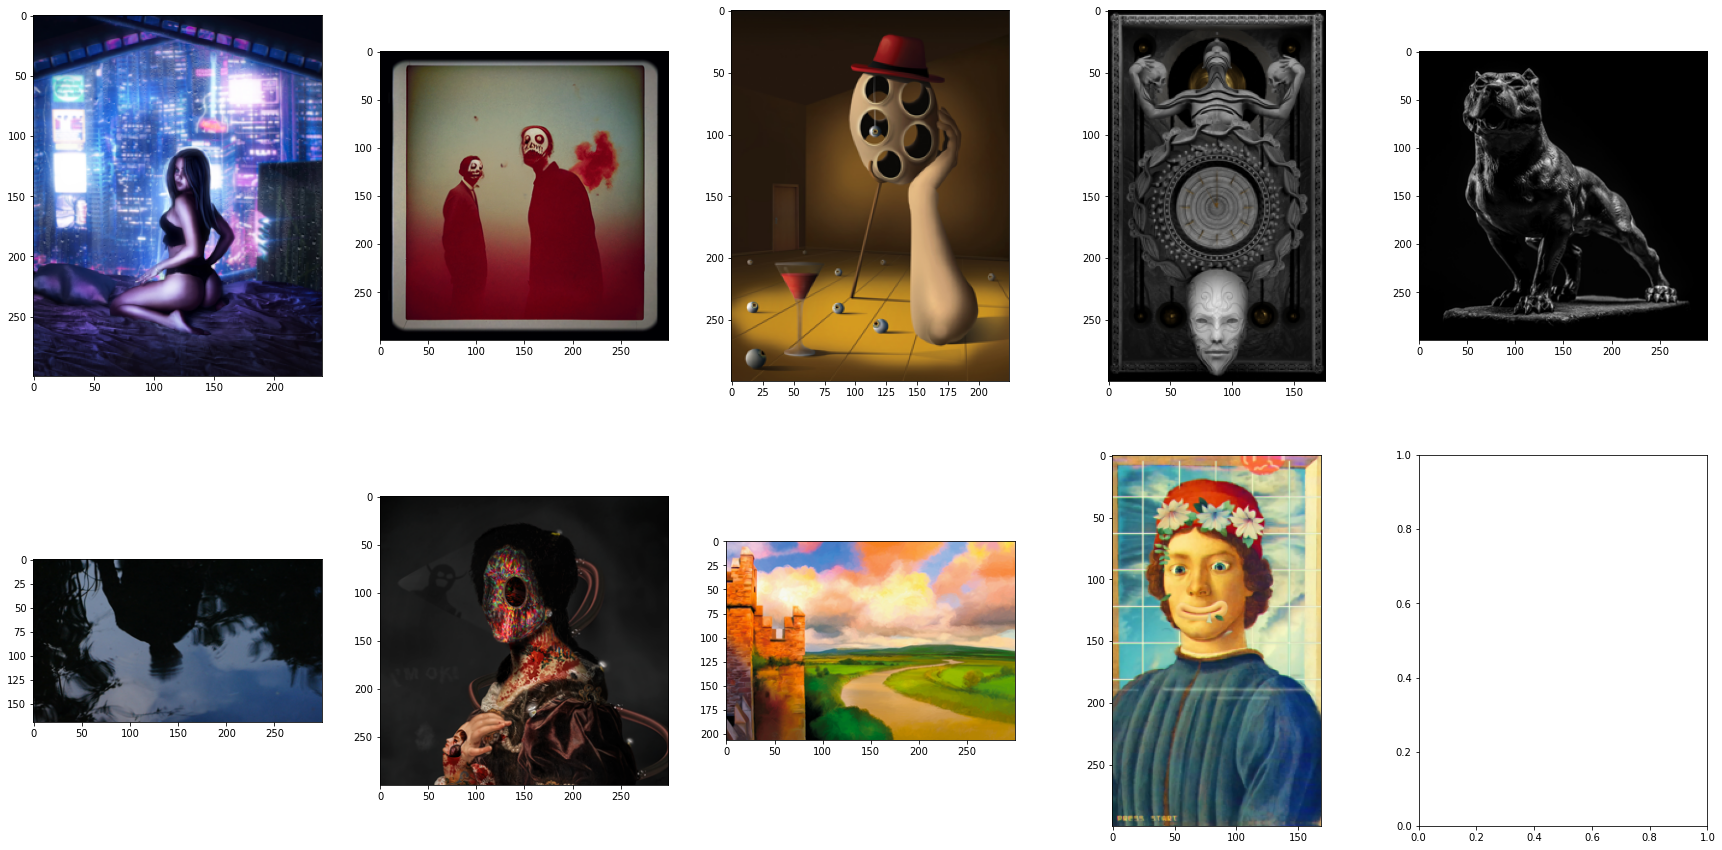

In [6]:
%%time
def load_resized_image(img_path, max_width = 300, max_height = 300):
    try:
        if 'http' in img_path:
            response = requests.get(img_path, stream=True)
            img = Image.open(requests.get(img_path, stream=True).raw)
        else:    
            img = Image.open(img_path).convert('RGB')
        width, height = img.size
        if width > max_width or height > max_height:
            img.thumbnail((max_width, max_height))
        img = np.asarray(img)
        return img    
    except Exception as e:
        print(f"IPFS ID:{img_path.split('/')[-1]} - {e}") 
        return None

img_local_paths = []
for imagePath in os.listdir(IMAGES_FOLDER)[:9]:
  img_local_paths.append(os.path.join(IMAGES_FOLDER, imagePath))

rows=2
cols=5
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(30,15))
for i in range(rows):
    for j in range(cols):        
        if img_count < len(img_local_paths):
            axes[i, j].imshow(load_resized_image(img_local_paths[img_count]))
            img_count+=1

# 3 - Download Clip Model

In [7]:
%%time
from transformers import CLIPTokenizer, CLIPTextModelWithProjection, CLIPProcessor, CLIPVisionModelWithProjection, TFCLIPTextModel, TFCLIPVisionModel

DIMENSIONS = 768
clip_model_id = "openai/clip-vit-large-patch14"

text_model = CLIPTextModelWithProjection.from_pretrained(clip_model_id)
tokenizer = CLIPTokenizer.from_pretrained(clip_model_id)

vision_model = CLIPVisionModelWithProjection.from_pretrained(clip_model_id)
processor = CLIPProcessor.from_pretrained(clip_model_id)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vision_model.to(device)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModelWithProjection: ['vision_model.encoder.layers.21.self_attn.q_proj.weight', 'vision_model.encoder.layers.20.self_attn.out_proj.bias', 'vision_model.encoder.layers.12.mlp.fc1.bias', 'vision_model.encoder.layers.3.mlp.fc2.weight', 'vision_model.encoder.layers.2.self_attn.v_proj.bias', 'vision_model.encoder.layers.16.layer_norm1.weight', 'vision_model.encoder.layers.6.mlp.fc1.bias', 'vision_model.encoder.layers.6.self_attn.v_proj.bias', 'vision_model.encoder.layers.15.self_attn.q_proj.weight', 'vision_model.encoder.layers.0.self_attn.out_proj.weight', 'vision_model.encoder.layers.5.mlp.fc1.bias', 'vision_model.encoder.layers.14.self_attn.v_proj.bias', 'vision_model.encoder.layers.13.layer_norm2.bias', 'vision_model.encoder.layers.16.self_attn.k_proj.bias', 'vision_model.encoder.layers.8.self_attn.out_proj.bias', 'vision_model.encoder.layers.1.self_attn.out_proj.weight', 'visio

CPU times: user 9.65 s, sys: 5.56 s, total: 15.2 s
Wall time: 23.7 s


CLIPVisionModelWithProjection(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (position_embedding): Embedding(257, 1024)
    )
    (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096,

# 4 - Create Faiss Index

In [8]:
storage = "Flat"
index_name = f"IDMap,{storage}"
image_index = faiss.index_factory(DIMENSIONS, index_name)

In [9]:
def get_text_embeds(queries):
  inputs = tokenizer(queries, padding=True, return_tensors="pt")
  outputs = text_model(**inputs)
  return outputs.text_embeds.detach().numpy()

print(get_text_embeds(["a photo of a cat", "a photo of a dog"]).shape)

(2, 768)


# 5 - Index Images

In [10]:
%%time
image_ids_map = {}
image_embeds = None

with torch.no_grad():
    torch.cuda.empty_cache()

def get_embeds(images):
  inputs = processor(images=images, return_tensors="pt")
  inputs = inputs.to(device)
  outputs = vision_model(**inputs)
  return outputs.image_embeds

def build_index():
  
    image_batch = []
    image_ids = []
    embeds_count = 0
    for image_id in os.listdir(IMAGES_FOLDER):

        inputPath = os.path.join(IMAGES_FOLDER, image_id)   
        # print(f"{inputPath}")
        loaded_image = load_resized_image(inputPath, 1200, 1200)
        if loaded_image is not None:
            image_batch.append(loaded_image)
            hash_value = hash(inputPath)
            image_ids.append(hash_value)
            image_ids_map[hash_value] = image_id
            
            if len(image_batch) == VISION_MODEL_INPUT_BATCH_SIZE:     
                image_embeds_batch = get_embeds(image_batch)
                #   print(image_embeds_batch.shape)
                image_embeds_batch = image_embeds_batch.to(torch.device("cpu"))        
                image_index.add_with_ids(image_embeds_batch.detach().numpy(), np.array(image_ids))
                embeds_count+=VISION_MODEL_INPUT_BATCH_SIZE      
                if embeds_count%1000 == 0:
                    print(f"Created embeds for {embeds_count} images")
                image_ids = []
                image_batch = []
    if len(image_batch) > 0:
        image_embeds_batch = get_embeds(image_batch)
        print(image_embeds_batch.shape)
        image_embeds_batch = image_embeds_batch.to(torch.device("cpu"))        
        image_index.add_with_ids(image_embeds_batch.detach().numpy(), np.array(image_ids))


image_embeds = build_index()

Created embeds for 1000 images


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:2797: DecompressionBombWarning: Image size (104621838 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:2797: DecompressionBombWarning: Image size (94133724 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Created embeds for 2000 images
Created embeds for 3000 images
Created embeds for 4000 images
Created embeds for 5000 images
IPFS ID:QmVM7JgrY8ULfKnGYB1oFgBU2WLHpf4mWuuinVbR6PhECw - Image size (180000000 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
IPFS ID:QmcASnR45dkG3xrGFFAei2VUHLK8U8t367bEQTKwUAFkhA - Image size (180000000 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Created embeds for 6000 images
Created embeds for 7000 images


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:2797: DecompressionBombWarning: Image size (108658233 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Created embeds for 8000 images
IPFS ID:QmaFgff6yeTrJiVUDic8rC7AHHa9vPBVaN4Rh7NXjnFhfr - Image size (180000000 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Created embeds for 9000 images
Created embeds for 10000 images


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:2797: DecompressionBombWarning: Image size (112987156 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


IPFS ID:QmR1B8i9a1akuHceBLgVYYEoQpMQFzQQ2TkETyh88X7424 - Image size (180000000 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
torch.Size([5, 768])
CPU times: user 34min 38s, sys: 50.9 s, total: 35min 29s
Wall time: 37min 20s


# 6 - Query Index

In [11]:
%%time
searh_embeds = get_embeds(load_resized_image(img_local_paths[1], 1200, 1200)).cpu().detach().numpy()
print(searh_embeds.shape)

probabilities, ids = image_index.search(searh_embeds, 16)
print(ids)
print(probabilities)

(1, 768)
[[-7310006910498023531 -2109695784747379715 -7704617341249186973
  -5338322920315714625  4898780517472335147 -5046032136638231174
  -5331271512385321662 -5183800241875317934  6540116447980792565
   5706226010409078882  3947587644137863352  2552457050492297139
  -5445274663493737035  8025943479106759357  1254821440960481467
  -8662939763396014048]]
[[8.86161089e-10 1.20562637e+02 1.20953751e+02 1.25255951e+02
  1.27197876e+02 1.27266998e+02 1.31448532e+02 1.33747528e+02
  1.47434174e+02 1.49165085e+02 1.53118073e+02 1.54858322e+02
  1.54959518e+02 1.58810104e+02 1.63470810e+02 1.63618118e+02]]
CPU times: user 75.1 ms, sys: 2.97 ms, total: 78.1 ms
Wall time: 131 ms


# 7 - Display Results

CPU times: user 536 ms, sys: 11 ms, total: 547 ms
Wall time: 635 ms


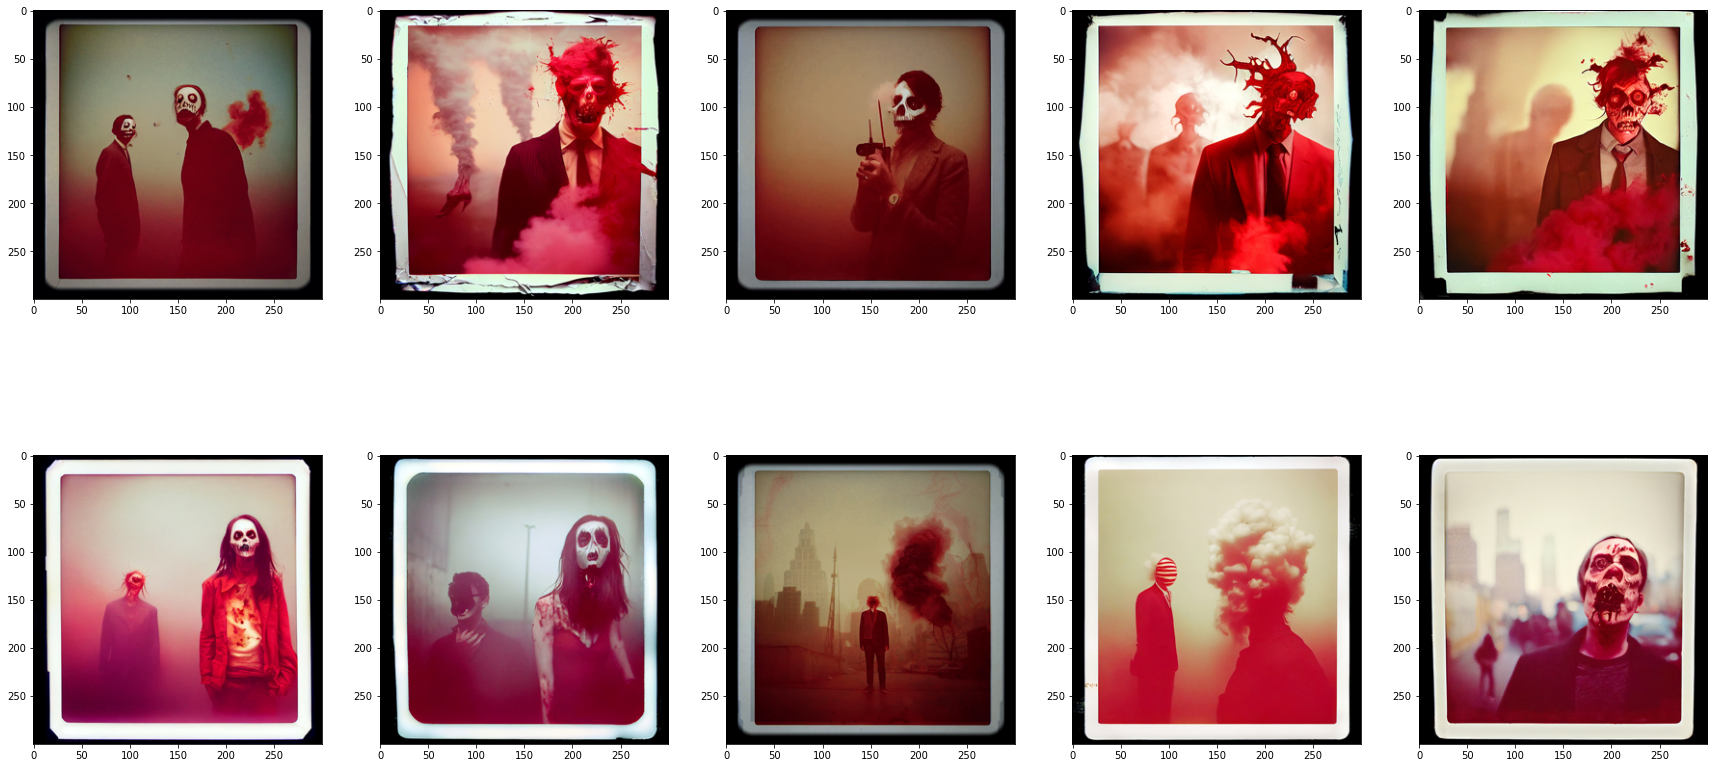

In [12]:
%%time
def display_search_results(search_results, local_image_ids_map, rows=2, cols=5):
    img_count = 0
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(30,15))
    for i in range(rows):
        for j in range(cols):        
            if img_count < len(search_results):
                image_hash = local_image_ids_map[search_results[img_count]]
                inputPath = os.path.join(IMAGES_FOLDER, image_hash)  
                axes[i, j].imshow(load_resized_image(inputPath))
                img_count+=1

display_search_results(ids[0], image_ids_map)            

# Search index using Random images

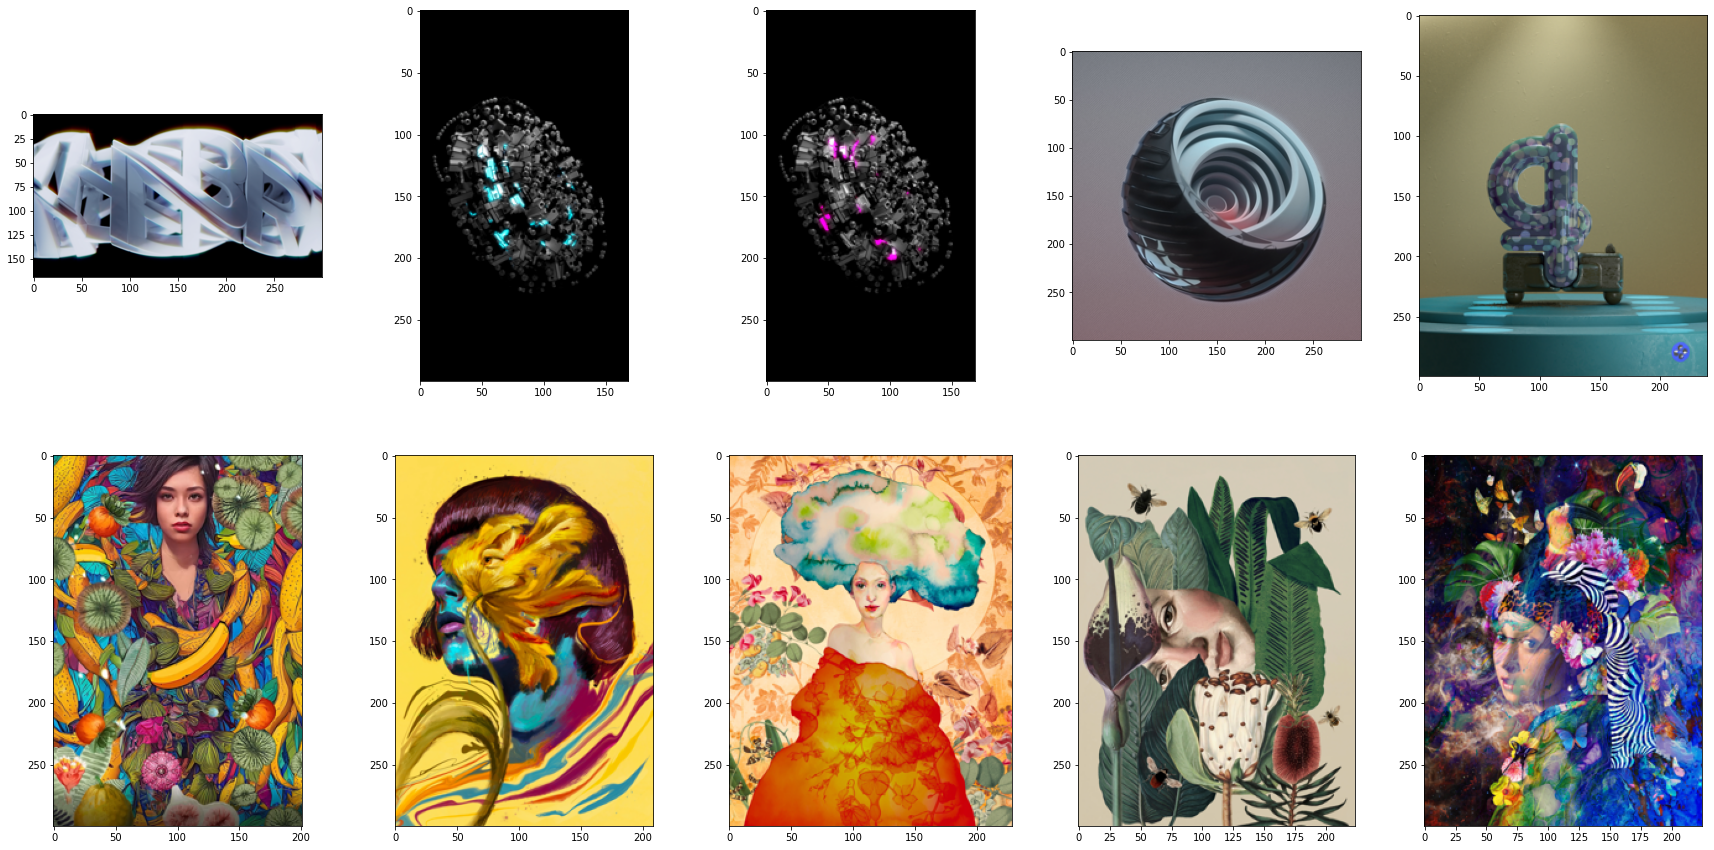

In [16]:
search_count = 2
search_images = np.random.randint(0, len(image_names), search_count)

def search_images_in_index(image_index, search_images):
    search_results = []
    for i in search_images:
        image_path = os.path.join(IPFS_GATEWAY,image_names[i])
        try:
            searh_embeds = get_embeds(load_resized_image(image_path, 1200, 1200)).cpu().detach().numpy()
        
            _, image_ids = image_index.search(searh_embeds, 5)
            search_results.extend(image_ids[0])
        except Exception as e:
            print(f"Bad Image IPFS ID:{image_names[i]} - {e}") 
    return search_results    

display_search_results(search_images_in_index(image_index, search_images), image_ids_map, 2, 5)


# Save and load Faiss Index and Image Id map

In [17]:
prefix = index_name.replace(',', '_')
index_file_name = f"{prefix}.index"
index_path = os.path.join(INDEX_FOLDER, index_file_name)
faiss.write_index(image_index, index_path)

id_map_file_name = f"{prefix}_image_ids.pickle"
id_map_path = os.path.join(INDEX_FOLDER, id_map_file_name)
with open(id_map_path, 'wb') as f:
    pickle.dump(image_ids_map, f)

shutil.make_archive(f"{INDEX_FOLDER}", 'zip', INDEX_FOLDER)

# Read index
loaded_image_index = faiss.read_index(index_path)

# Read id map
with open(id_map_path, 'rb') as f:
    loaded_image_ids_map = pickle.load(f)

# Search loaded Index using random Images

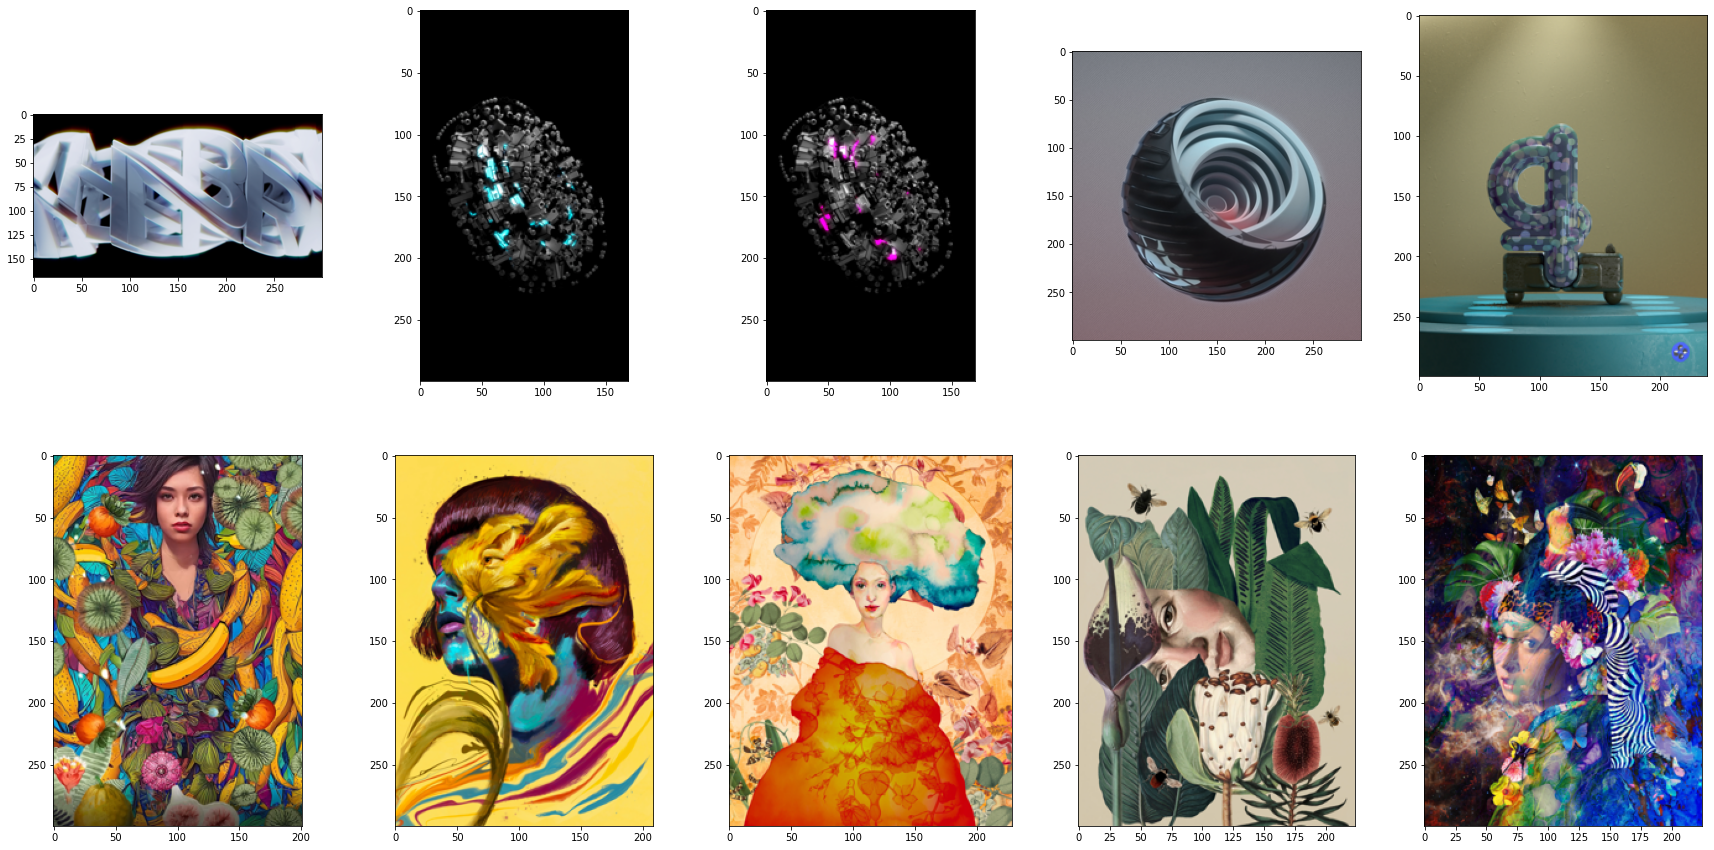

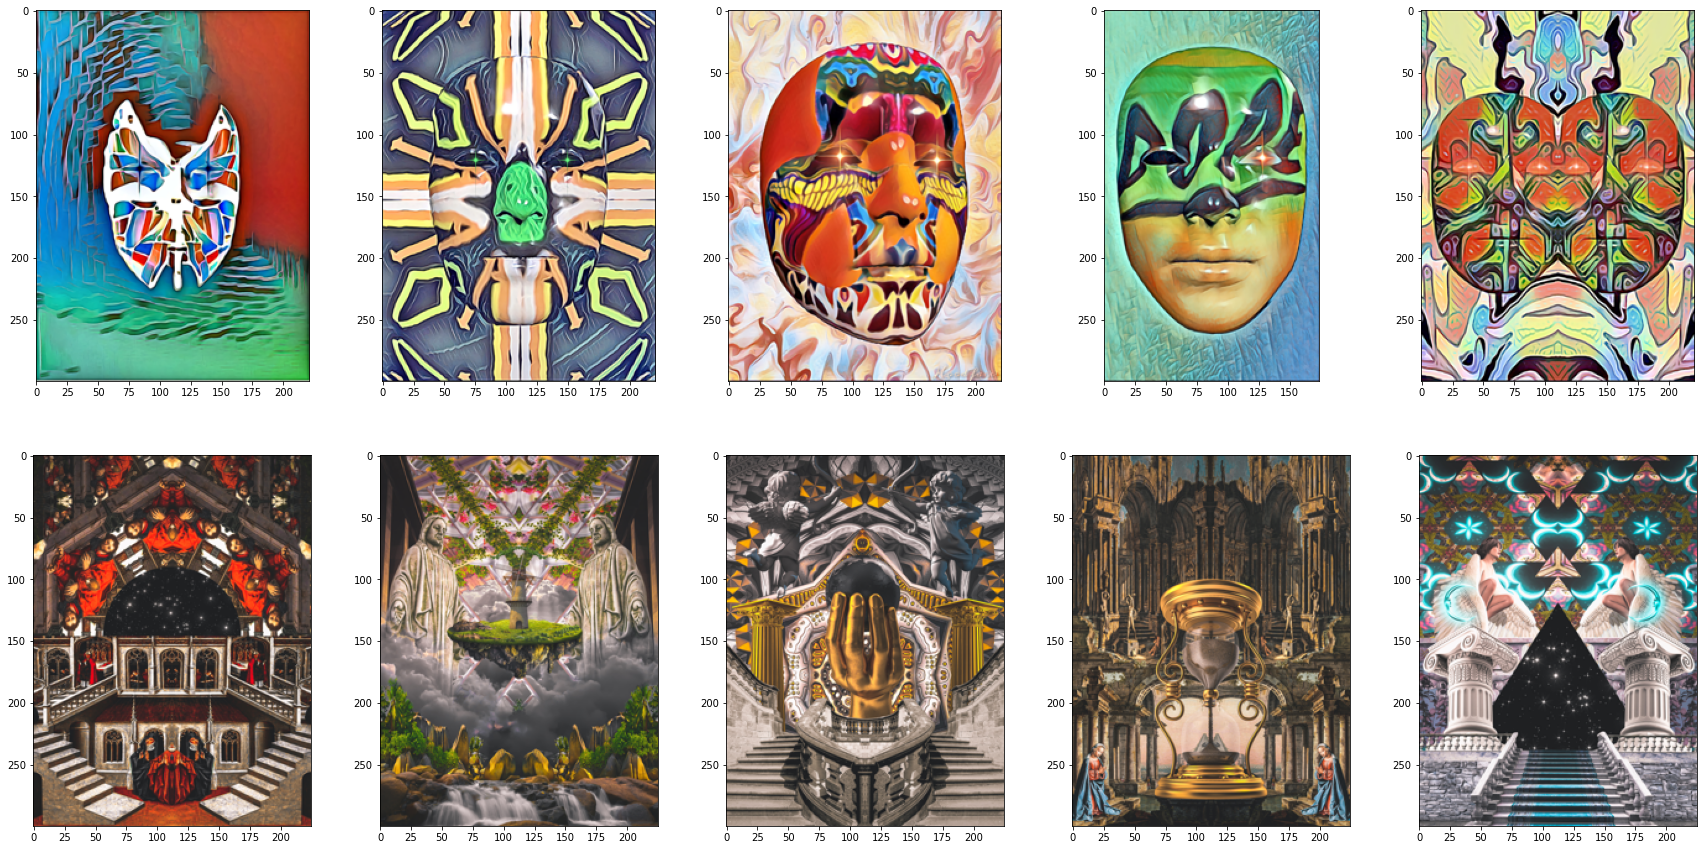

In [18]:
#repeat search using past images to verify index saving and loading
display_search_results(
    search_images_in_index(loaded_image_index, search_images), 
    loaded_image_ids_map,
    2, 
    5)

# Perform new random search
new_search_images = np.random.randint(0, len(image_names), search_count)
display_search_results(
    search_images_in_index(loaded_image_index, new_search_images), 
    loaded_image_ids_map,
    2, 
    5)


In [19]:
torch.cuda.empty_cache()

In [20]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 27 02:56:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    44W /  70W |   2442MiB / 15109MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------